# Predicting California Housing Prices
We will use the California Housing Prices dataset. This dataset was based on data from the 1990 California census. It is not exactly recent, but it has many qualities for learning, so we will pretend it is recent data.

Dataset columns description:
- MedInc        median income in block
- HouseAge      median house age in block
- AveRooms      average number of rooms
- AveBedrms     average number of bedrooms
- Population    block population
- AveOccup      average house occupancy
- Latitude      house block latitude
- Longitude     house block longitude

In [2]:
# Data manipulation and Linear Algebra
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [5]:
# load data
df = pd.read_csv('housing.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


##### Some Insights:
- we have 10 columns (9 numerical, and 1 categorical).
- we have 20640 rows.
- we have missing data in total_bedrooms.

In [7]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [54]:
df[df['households']==1].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
16171,-122.5,37.79,52.0,8.0,1.0,13.0,1.0,15.0001,500001.0,NEAR BAY


##### Some Insights:
- we have relatively small values and big values in many numerical values, and that's maybe an indicator for outliers.

In [9]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

### 1. Data Preproccessing:

#### 1.1 Checking outliers:

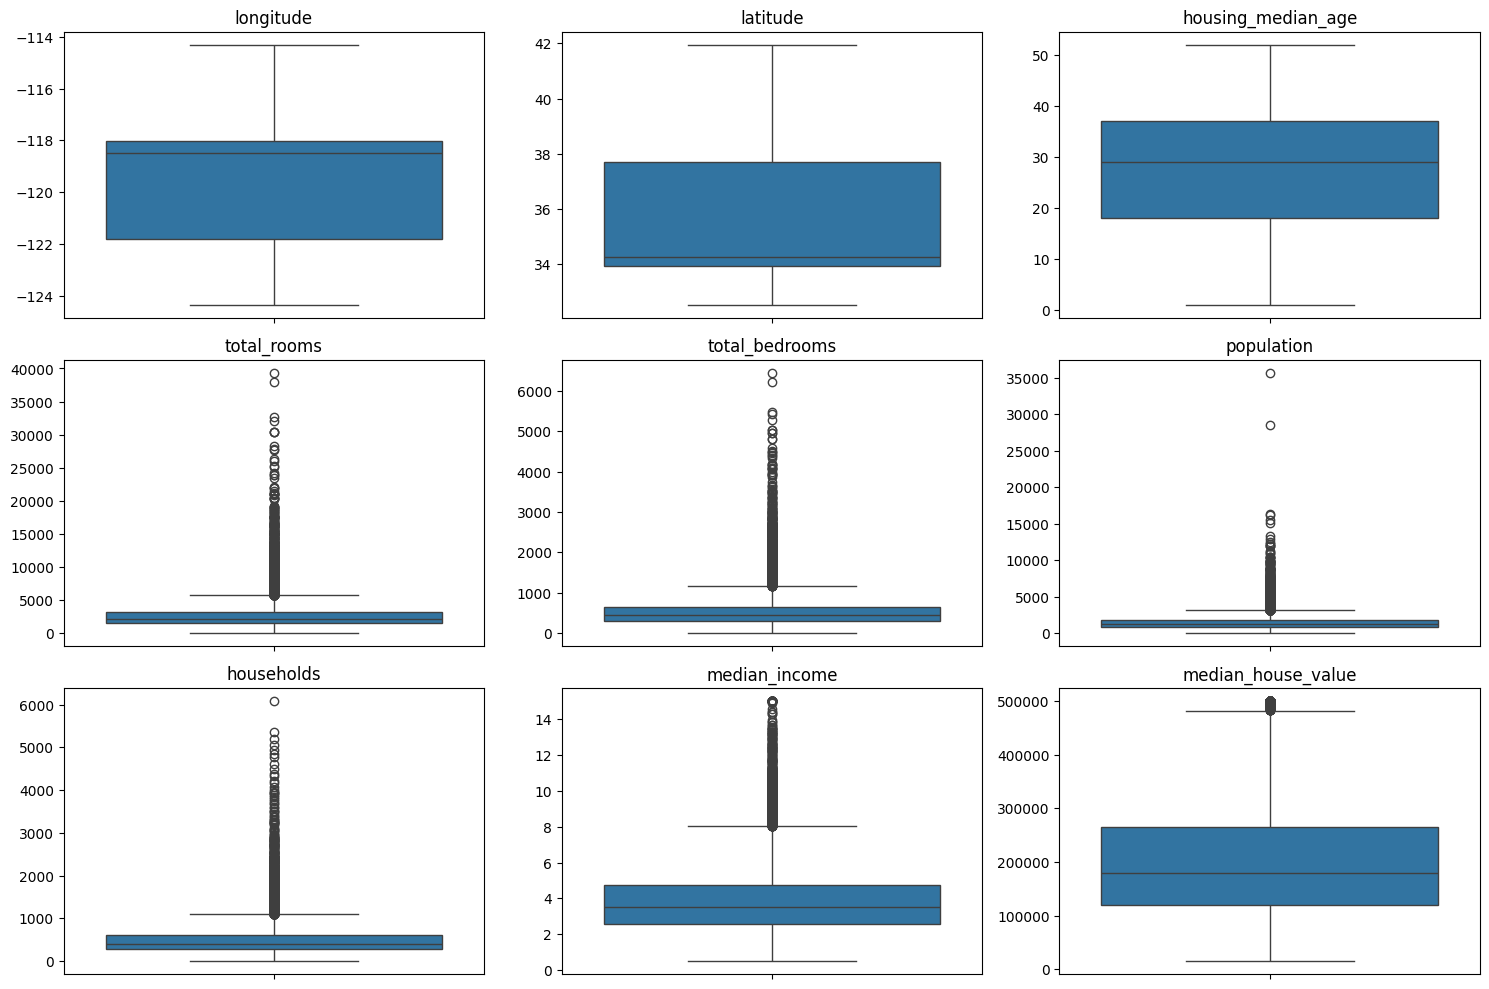

In [58]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

for name, ax in zip(num_cols, axes.flatten()):
    sns.boxplot(df[name], ax=ax, orient='v')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
plt.tight_layout()
plt.show()

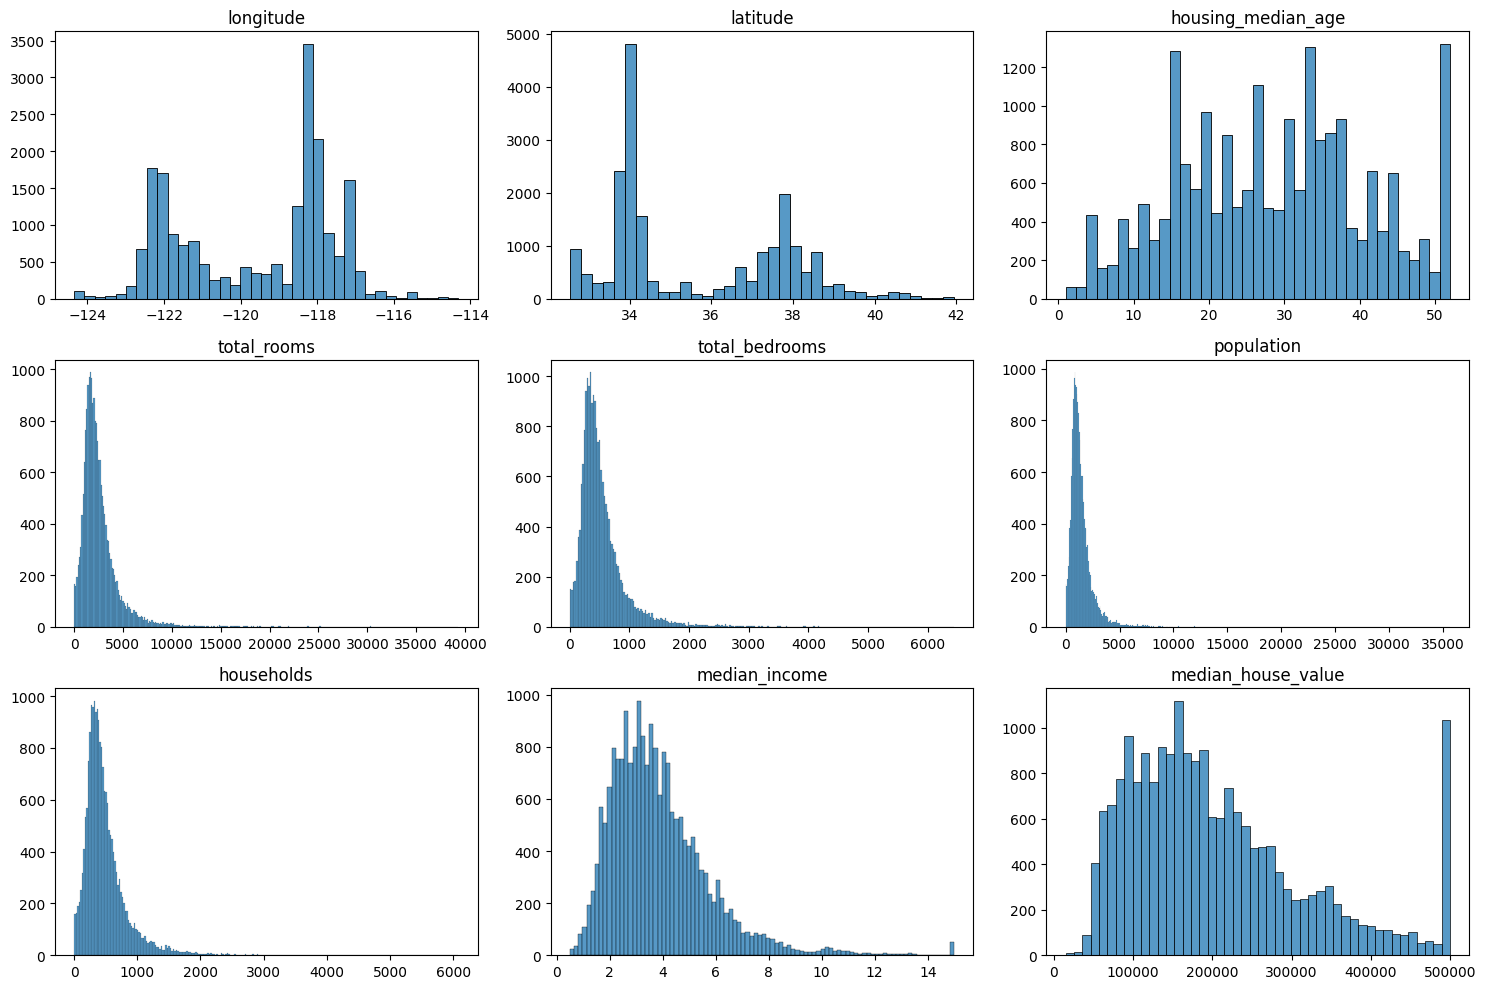

In [59]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

for name, ax in zip(num_cols, axes.flatten()):
    sns.histplot(df[name], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [47]:
def getOutliers(data: pd.DataFrame, column_names: list) -> tuple:
    first_quartile = data[column_names].quantile(0.25)
    third_quartile = data[column_names].quantile(0.75)
    IQR = third_quartile - first_quartile
    max_thresold = third_quartile + (1.5 * IQR)
    min_thresold = first_quartile - (1.5 * IQR)
    return (min_thresold, max_thresold, data[((data[column_names]>max_thresold) | (data[column_names]<min_thresold))['households']])

In [48]:
min_, max_, outliers = getOutliers(df.copy(), ['households'])
outliers.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
95,-122.26,37.80,36.0,5329.0,2477.0,3469.0,2323.0,2.0096,130000.0,NEAR BAY
96,-122.26,37.82,31.0,4596.0,1331.0,2048.0,1180.0,2.8345,183800.0,NEAR BAY
98,-122.26,37.82,22.0,3682.0,1270.0,2024.0,1250.0,1.2185,170000.0,NEAR BAY
100,-122.25,37.81,29.0,4656.0,1414.0,2304.0,1250.0,2.4912,257800.0,NEAR BAY
